In [2]:
#rdmc prep 
import pandas as pd

FREQ_POPS = [
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--random2_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--random2_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
]

sweep_df = pd.read_csv("../data/raisd/v5--allpops--shared_outliers.txt", 
            sep = "\t", 
            names = ["chrom", "start", "end", "length", "files"])

sweep_idx = []
for sweep in sweep_df['files']:
    sweep_files = sweep.split(',')
    s_idx = [f"{i+1}" for i,x in enumerate(FREQ_POPS) for s in sweep_files if s.find(x) != -1]
    if len(s_idx) < 2 or len(s_idx) > len(FREQ_POPS)-2:
        sweep_idx.append("NA")
    else:
        sweep_idx.append('-'.join(s_idx))
        
sweep_df['sweep_idx'] = sweep_idx

out_file = [f"sweep_{row['chrom']}_start{str(row['start'])}_end{str(row['end'])}_pops{row['sweep_idx']}.txt" for index, row in sweep_df.iterrows()]
sweep_df['out_file'] = out_file
sweep_df[sweep_df['sweep_idx'] != "NA"]


"""

rule get_sweep:
    input:
        "data/rdmc/freq/allpops--{chrom}--{start}--{end}_freq.txt.gz"
    output:
        "{}"
    params:
        chrom = "{chrom}",
        start = "{start}",
        end = "{end}"
    shell:
    
    awk -v chrom={params.chrom} -v start={params.start} -v end={params.end} '$1==chrom && $2 >= start $$ $3 <= end {{print $0}}' {input} > {output}
    



rule rdmc_cli 
    input:
        gmap = "ogut something something"
        freq_file = ""
    output:
        sweep_{chr1}_start{start}_end{end}_pops{pops}.txt
    params:
        pops = "{pops}",
        start = "{start}",
        end = "{end}"
        
    shell:
    "rdmc_cli --pops {pops} --gmap {gmap} --freqs {freq_file} --start {start} --end {end} -g -s -t"
    
"""

out_file[0]

'sweep_chr1_start23160_end380776_pops6-7-8-9-13-14-15-16.txt'

In [10]:
import mushi

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import msprime
import tskit
from itertools import tee
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from glob import glob

In [4]:
t = np.logspace(np.log10(1), np.log10(1000000), 50)
mu = 3e-8
#mu = 1e-7
bps = 10000
c = 1.6e-8

sfs_files = glob("../data/angsd_pi/v5--LR--Palmar_Chico*.sfs")
sfs_list = []

for sfs_file in sfs_files:
    with open(sfs_file) as f:
        sfs = f.readlines()[0].split()
        sfs_chr = np.array([float(s) for s in sfs])
        sfs_list.append(sfs_chr)

sfs_array = np.asarray(sfs_list)
sfs_all = sfs_array.sum(axis=0)
print(sfs_all)

ksfs = mushi.kSFS(np.array(sfs_all[1:-1]))
ksfs.infer_history(t, mu0 = mu*sum(sfs_all), infer_mu=False, folded = False,
                   alpha_tv=1e1, alpha_spline=1e1, alpha_ridge = 1e-4,
                   tol=1e-12, verbose=True, max_iter = 5000)

[4.36633475e+08 2.91931316e+06 2.25127341e+06 1.74401863e+06
 1.41941808e+06 1.14544306e+06 9.09551982e+05 7.86321002e+05
 6.00326418e+05 5.25119261e+05 4.56369575e+05 4.17360462e+05
 3.61712165e+05 3.17084019e+05 2.95351880e+05 2.64600625e+05
 2.38130811e+05 2.15446520e+05 2.07047099e+05 2.00210490e+05
 1.60117800e+05 1.50862333e+05 1.53539344e+05 1.36087870e+05
 1.41431026e+05 1.21004331e+05 1.17919190e+05 1.09202535e+05
 1.03036894e+05 9.42090725e+04 9.52642716e+04 8.84190590e+04
 8.58711489e+04 8.07705509e+04 7.87613513e+04 7.25394911e+04
 7.02607351e+04 6.66769992e+04 6.64457648e+04 6.31574275e+04
 5.78660329e+04 5.73178725e+04 5.55756910e+04 5.23846399e+04
 4.88238676e+04 5.28941296e+04 4.93506877e+04 4.50633489e+04
 4.60666863e+04 4.63852534e+04 4.31682625e+04 4.20759716e+04
 4.09902014e+04 3.76624737e+04 3.81640374e+04 4.07549877e+04
 3.06942217e+04 3.16411313e+04 3.15768914e+04 3.05639598e+04
 3.08047341e+04 3.06020372e+04 2.85039165e+04 2.77367756e+04
 2.78755377e+04 2.721154

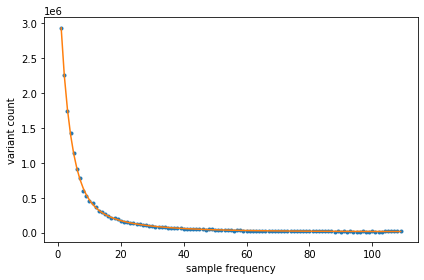

Rectangle(xy=(350, 0), width=1000, height=1e+07, angle=0)


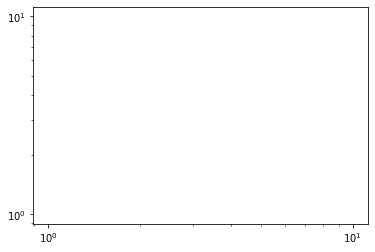

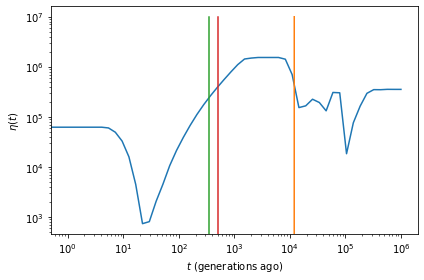

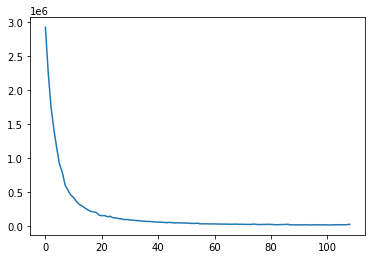

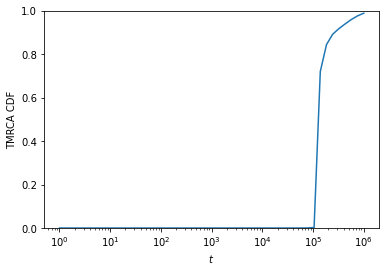

In [5]:
ksfs.plot_total()
plt.show()
plt.xscale('log')
plt.yscale('log')

fig, ax = plt.subplots()
ksfs.eta.plot()
plt.plot((8000, 12000), (0, 1e7))
plt.plot((350, 350), (0, 1e7))
plt.plot((500, 500), (0, 1e7))
rect = Rectangle((350,0), 1000, 1e7, color = 'black', fill = True, alpha = 1)
print(rect)
plt.show()
plt.plot(sfs_all[1:-1])
plt.show()

plt.plot(t, ksfs.tmrca_cdf(ksfs.eta))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.show()


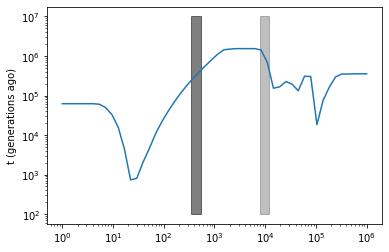

In [6]:
fig, ax = plt.subplots()
Nt = ksfs.eta.vals
T = ksfs.eta.change_points
rect1 = Rectangle((350,1e2), 200, 1e7, color = 'black', fill = True, alpha = 0.5)
rect2 = Rectangle((8000,1e2), 4000, 1e7, color = 'black', fill = True, alpha = 0.25)
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.plot(T, Nt[1:])
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\eta(t)$')
plt.ylabel('t (generations ago)')
plt.show()


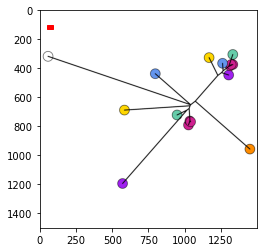

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('../figures/raw_tree.png')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='red')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


In [15]:
Nt = ksfs.eta.vals
T = ksfs.eta.change_points

N_0 = Nt[0] / 2
msp_N = Nt[1:] / 2
msp_T = T
nsamp = len(sfs_all)-1

#ms_N = Nt[1:]/N_0
#ms_T = T/(4*N_0)


population_configurations = [msprime.PopulationConfiguration(sample_size = nsamp, initial_size = N_0)]
demography_list = [msprime.PopulationParametersChange(time = t, initial_size = n) for t, n, in zip(msp_T, msp_N)]

ts_mushi = msprime.simulate(
    population_configurations=population_configurations, 
    demographic_events = demography_list, 
    #Ne = N_0, sample_size = nsamp,
    #length = bps, 
    length = 5e6, 
    recombination_rate = c, 
    mutation_rate = mu, 
    num_replicates = 1
)

#ts_mushi, ts_mushi_copy = tee(ts_mushi)

#pi = [ts.diversity() for ts in ts_mushi]
#td = [ts.Tajimas_D() for ts in ts_mushi]

#print(np.nanmean(list(map(lambda a : [a.diversity().item(), a.Tajimas_D().item()], ts_mushi)), axis=0))
#list(map(lambda a : [a.diversity().item(), a.Tajimas_D().item()], ts_mushi))


In [16]:
ts = next(ts_mushi)
ts = msprime.mutate(ts, rate=mu, model=msprime.InfiniteSites(alphabet=msprime.NUCLEOTIDES))
with open("../test.vcf", "w") as vcf_file:
    ts.write_vcf(vcf_file, ploidy=2)

In [17]:
%%bash 
java -jar ../src/ibdseq.r1206.jar gt=../test.vcf out=../test_ibdseq.txt nthreads=2 r2max=0.7

Program           :  ibdseq r1206  (max memory: 3072 MB)
Start Time        :  01:18 PM PDT on 08 Apr 2021

Parameters
  gt              :  ../test.vcf
  out             :  ../test_ibdseq.txt
  minalleles      :  2
  ibdlod          :  3.0
  ibdtrim         :  0.0
  errormax        :  0.001
  errorprop       :  0.25
  r2window        :  500
  r2max           :  0.7
  nthreads        :  2

Estimated finish  : 01:27 PM PDT on 08 Apr 2021

Data Statistics
  samples         :  55
  markers         :  217745
   >= minalleles  :  186417
   LD-thinned     :  52416  (24% of markers)
  segments/sample :  510.4
  mean IBD length :  0.04 Mb
  mean IBD depth  :  8.8

Wallclock Time:   :  1 minutes 5 seconds
End Time          :  01:19 PM PDT on 08 Apr 2021


In [44]:
def sim_hbd(file_glob, vcfout, hbdout, mu = 3e-8, c = 1.6e-8, bps = 5e6):
    
    t = np.logspace(np.log10(1), np.log10(1000000), 50)
    sfs_files = glob(file_glob)
    sfs_list = []

    for sfs_file in sfs_files:
        with open(sfs_file) as f:
            sfs = f.readlines()[0].split()
            sfs_chr = np.array([float(s) for s in sfs])
            sfs_list.append(sfs_chr)

    sfs_array = np.asarray(sfs_list)
    sfs_all = sfs_array.sum(axis=0)

    ksfs = mushi.kSFS(np.array(sfs_all[1:-1]))
    ksfs.infer_history(t, mu0 = mu*sum(sfs_all), infer_mu=False, folded = False,
                       alpha_tv=1e4, alpha_spline=1e4, alpha_ridge = 1e-1,
                       tol=1e-12, verbose=True, max_iter = 5000)

    Nt = ksfs.eta.vals
    T = ksfs.eta.change_points

    N_0 = Nt[0] / 2
    msp_N = Nt[1:] / 2
    msp_T = T
    nsamp = len(sfs_all)-1

    population_configurations = [msprime.PopulationConfiguration(sample_size = nsamp, initial_size = N_0)]
    demography_list = [msprime.PopulationParametersChange(time = t, initial_size = n) for t, n, in zip(msp_T, msp_N)]

    ts_mushi = msprime.simulate(
        population_configurations=population_configurations, 
        demographic_events = demography_list, 
        length = bps, 
        recombination_rate = c, 
        mutation_rate = mu, 
        num_replicates = 1
    )
    
    
    ts = next(ts_mushi)
    ts = msprime.mutate(ts, rate=mu, model=msprime.InfiniteSites(alphabet=msprime.NUCLEOTIDES))
    
    with open(vcfout, "w") as vcf_file:
        ts.write_vcf(vcf_file, ploidy=2)
    
    os.system(f"java -jar ../src/ibdseq.r1206.jar gt={vcfout} out={hbdout} nthreads=2 r2max=0.7")

sim_hbd("../data/angsd_pi/v5--Teo--random1_Palmar_Chico*.sfs", "../testPC.vcf", "../testPC_ibdseq.txt", mu = 3e-8, c = 1.6e-8, bps = 1e7)
sim_hbd("../data/angsd_pi/v5--Teo--San_Lorenzo*.sfs", "../testSLO.vcf", "../testSLO_ibdseq.txt", mu = 3e-8, c = 1.6e-8, bps = 1e7)

inferring η(t)
initial objective -2.783152e+08
iteration 361, objective -2.805e+08, relative change 7.942e-13        
relative change in objective function 7.9e-13 is within tolerance 1e-12 after 361 iterations
inferring η(t)
initial objective -1.011550e+08
iteration 718, objective -1.017e+08, relative change 2.513e-13        
relative change in objective function 2.5e-13 is within tolerance 1e-12 after 718 iterations


In [ ]:
%load_ext rpy2.ipython

                                                                                                                   
Columns: 8
Delimiter: "\t"
chr [2]: id1, id2
dbl [6]: hidx1, hidx2, chrom, start, end, lod

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

                                                                                                                   
Columns: 8
Delimiter: "\t"
chr [2]: id1, id2
dbl [6]: hidx1, hidx2, chrom, start, end, lod

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] 0


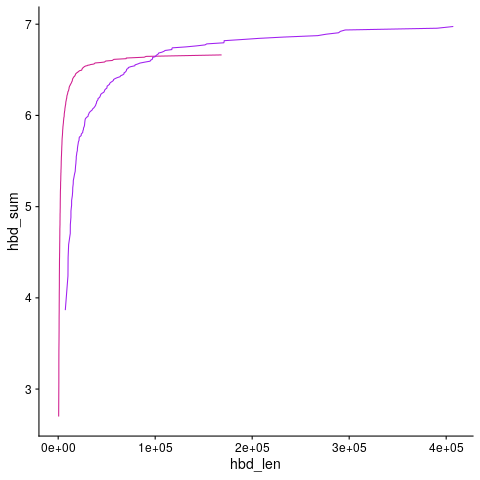

In [45]:
%%R 

library(tidyverse)

slo <- vroom::vroom(
    "../testSLO_ibdseq.txt.hbd", 
    col_names = c("id1", "hidx1", "id2", "hidx2", "chrom", "start", "end", "lod")
) %>%
  mutate(hbd_len = end-start) %>%
  arrange(hbd_len) %>%
  mutate(hbd_sum = log10(cumsum(hbd_len)))
  

pc <- vroom::vroom(
    "../testPC_ibdseq.txt.hbd", 
    col_names = c("id1", "hidx1", "id2", "hidx2", "chrom", "start", "end", "lod")
) %>%
  mutate(hbd_len = end-start) %>%
  arrange(hbd_len) %>%
  mutate(hbd_sum = log10(cumsum(hbd_len)))
  
print(sum(pc$len < 0))

ggplot() +
  geom_line(data = pc, mapping = aes(hbd_len, hbd_sum), col = "violetred") +
  geom_line(data = slo, mapping = aes(hbd_len, hbd_sum), color = "purple") +
  cowplot::theme_cowplot()


In [7]:
msp_N/N_0

DeviceArray([1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
             1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
             9.66072389e-01, 7.93645538e-01, 5.28008688e-01,
             2.55915902e-01, 7.20107426e-02, 1.18272776e-02,
             1.29746875e-02, 3.30243121e-02, 7.25149090e-02,
             1.70674288e-01, 3.42871518e-01, 6.25276123e-01,
             1.08425810e+00, 1.79368552e+00, 2.82146680e+00,
             4.25945932e+00, 6.24490127e+00, 8.97284120e+00,
             1.27364725e+01, 1.77760311e+01, 2.30389082e+01,
             2.40653086e+01, 2.47204914e+01, 2.47204914e+01,
             2.47204914e+01, 2.47204914e+01, 2.28394365e+01,
             1.12784062e+01, 2.46540819e+00, 2.67382738e+00,
             3.62038949e+00, 3.11484940e+00, 2.12332806e+00,
             4.94473143e+00, 4.86947622e+00, 2.95291728e-01,
             1.22696501e+00, 2.63287490e+00, 4.75334062e+00,
             5.63043138e+00, 5.61159454e+00, 5.70818714e+00,
             5.69691053e

In [89]:
2231 / 55000

0.040563636363636364

In [90]:
N_0 = Nt[0] / 2
msp_N = (Nt[1:] / 2).astype('int')
msp_T = (T).astype('int')
nsamp = len(sfs_all)-1

N_1 = msp_N[0:-1][::-1]
N_2 = msp_N[1:][::-1]

T_1 = msp_T[0:-1][::-1]
T_2 = msp_T[1:][::-1]

print(', '.join([str(i) for i in N_1]))
print(', '.join([str(i) for i in N_2]))

print(', '.join([str(max(msp_T) - i + 1) for i in T_2]))
print(', '.join([str(max(msp_T) - i) for i in T_1]))


12641, 12641, 12641, 12641, 12641, 12641, 12641, 35289, 77809, 98580, 98580, 98580, 98580, 98580, 98580, 86369, 68814, 52141, 39284, 30913, 26715, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320
12641, 12641, 12641, 12641, 12641, 12641, 12641, 12641, 35289, 77809, 98580, 98580, 98580, 98580, 98580, 98580, 86369, 68814, 52141, 39284, 30913, 26715, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320, 26320
1, 44102, 78478, 105274, 126161, 142443, 155135, 165028, 172740, 178751, 183437, 187089, 189936, 192156, 193886, 195234, 196285, 197105, 197744, 198241, 198630, 198932, 199168, 199352, 199495, 199607, 199694, 199762, 199814, 199856, 199888, 199913, 199932, 199948, 199960, 199969, 199976, 199982, 199986, 199989, 199

In [91]:
print(N_0)
((462.9318338034885  + 694.3977507052326)/2)/(4*3e-8*55000)

26320.720737689062


87676.48367490312

In [97]:
print(2 * 87676 * 0.001)
print(2 * N_0 * 0.001)

175.352
52.64144147537812
